# RQ 3.
Which of the loss weighting approaches for balancing target and non-target samples in a set of one-vs-rest classifiers (OvRs)
- Class weighting
- Hard Negative Mining
- Focal Loss

would improve the performance of multiclass classification task?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import itertools
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [3]:
arch = 'LeNet'            # LeNet_plus_plus       LeNet

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','MultiBinary':'BCE','OpenSetOvR':'OSOvR'}
approaches_full = {'SoftMax':'SoftMax','EOS':'Enropic Open-Set Loss','MultiBinary':'Multi BCE Loss','OpenSetOvR':'Open-Set One-vs-Rest Classifiers'}
seeds = [42,43,44,45,46,47,48,49,50,51]
num_classes = 10

CMAP = mpl.color_sequences['tab10']

### Data information - Individual

In [115]:
ovr_C_data_info = [
    {'info':['SmallScale', f'{arch}_neg_All', 'OvR'], 'label': 'OvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_C_g', 'OvR'], 'label': 'OvR-C (Global)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_C_b', 'OvR'], 'label': 'OvR-C (Batch)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
]
osovr_C_data_info = [
    {'info':['SmallScale', f'{arch}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_C_g', 'OpenSetOvR'], 'label': 'OSOvR-C (Global)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_C_b', 'OpenSetOvR'], 'label': 'OSOvR-C (Batch)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
]




ovr_F_data_info = [
    {'info':['SmallScale', f'{arch}_neg_All', 'OvR'], 'label': 'OvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_F_02', 'OvR'], 'label': 'OvR-F (0.2)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_F_06', 'OvR'], 'label': 'OvR-F (0.6)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
    {'info':['SmallScale', f'{arch}_F_1', 'OvR'], 'label': 'OvR-F (1)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', f'{arch}_F_2', 'OvR'], 'label': 'OvR-F (2)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[3]},
    {'info':['SmallScale', f'{arch}_F_3', 'OvR'], 'label': 'OvR-F (3)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[4]},
]
osovr_F_data_info = [
    {'info':['SmallScale', f'{arch}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_F_02', 'OpenSetOvR'], 'label': 'OSOvR-F (0.2)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_F_06', 'OpenSetOvR'], 'label': 'OSOvR-F (0.6)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
    {'info':['SmallScale', f'{arch}_F_1', 'OpenSetOvR'], 'label': 'OSOvR-F (1)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', f'{arch}_F_2', 'OpenSetOvR'], 'label': 'OSOvR-F (2)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[3]},
    {'info':['SmallScale', f'{arch}_F_3', 'OpenSetOvR'], 'label': 'OSOvR-F (3)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[4]},
]




ovr_M_data_info = [
    {'info':['SmallScale', f'{arch}_neg_All', 'OvR'], 'label': 'OvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_M_02', 'OvR'], 'label': 'OvR-M (0.2)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_M_04', 'OvR'], 'label': 'OvR-M (0.4)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
    {'info':['SmallScale', f'{arch}_M_06', 'OvR'], 'label': 'OvR-M (0.6)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', f'{arch}_M_08', 'OvR'], 'label': 'OvR-M (0.8)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[3]},
]
osovr_M_data_info = [
    {'info':['SmallScale', f'{arch}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_M_02', 'OpenSetOvR'], 'label': 'OSOvR-M (0.2)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_M_04', 'OpenSetOvR'], 'label': 'OSOvR-M (0.4)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
    {'info':['SmallScale', f'{arch}_M_06', 'OpenSetOvR'], 'label': 'OSOvR-M (0.6)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', f'{arch}_M_08', 'OpenSetOvR'], 'label': 'OSOvR-M (0.8)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[3]},
]



# Final comparison for individual approaches
ovr_osovr_data_info = [
    {'info':['SmallScale', f'{arch}_neg_All', 'OvR'], 'label': 'OvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_C_b', 'OvR'], 'label': 'OvR-C (Batch)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_F_3', 'OvR'], 'label': 'OvR-F (3)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
    {'info':['SmallScale', f'{arch}_M_04', 'OvR'], 'label': 'OvR-M (0.4)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},

    {'info':['SmallScale', f'{arch}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_C_b', 'OpenSetOvR'], 'label': 'OSOvR-C (Batch)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_F_3', 'OpenSetOvR'], 'label': 'OSOvR-F (3)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
    {'info':['SmallScale', f'{arch}_M_04', 'OpenSetOvR'], 'label': 'OSOvR-M (0.4)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
]


### Data information - Combination

In [138]:
ovr_combi_data_info = [
    {'info':['SmallScale', f'{arch}_neg_All', 'OvR'], 'label': 'OvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_CM_b-04', 'OvR'], 'label': 'OvR-CM', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_FC_3-b', 'OvR'], 'label': 'OvR-FC', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
    {'info':['SmallScale', f'{arch}_FM_3-04', 'OvR'], 'label': 'OvR-FM', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', f'{arch}_FCM_3-b-04', 'OvR'], 'label': 'OvR-FCM', 'linestyle': '-', 'marker': 'o', 'color': CMAP[3]},
]
osovr_combi_data_info = [
    {'info':['SmallScale', f'{arch}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_CM_b-04', 'OpenSetOvR'], 'label': 'OSOvR-CM', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_FC_3-b', 'OpenSetOvR'], 'label': 'OSOvR-FC', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
    {'info':['SmallScale', f'{arch}_FM_3-04', 'OpenSetOvR'], 'label': 'OSOvR-FM', 'linestyle': '-', 'marker': 'o', 'color': CMAP[2]},
    {'info':['SmallScale', f'{arch}_FCM_3-b-04', 'OpenSetOvR'], 'label': 'OSOvR-FCM', 'linestyle': '-', 'marker': 'o', 'color': CMAP[3]},
]

# Final comparison for individual approaches
ovr_osovr_combi_data_info = [
    {'info':['SmallScale', f'{arch}_neg_All', 'OvR'], 'label': 'OvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_F_3', 'OvR'], 'label': 'OvR-F (3)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_FM_3-04', 'OvR'], 'label': 'OvR-FM', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},


    {'info':['SmallScale', f'{arch}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR', 'linestyle': '--', 'marker': 's', 'color': 'black'},
    {'info':['SmallScale', f'{arch}_F_3', 'OpenSetOvR'], 'label': 'OSOvR-F (3)', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},
    {'info':['SmallScale', f'{arch}_FCM_3-b-04', 'OpenSetOvR'], 'label': 'OSOvR-FCM', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
]

### Final comparison (Best for each)

In [182]:
# Final comparison with EOS
ovr_osovr_final_data_info = [
    {'info':['SmallScale', f'{arch}', 'EOS'], 'label': 'EOS', 'linestyle': '--', 'marker': '*', 'color': 'black'},

    {'info':['SmallScale', f'{arch}_neg_All', 'OvR'], 'label': 'OvR', 'linestyle': '-', 'marker': 's', 'color': CMAP[0], 'alpha':0.2},
    {'info':['SmallScale', f'{arch}_FM_3-04', 'OvR'], 'label': 'OvR-FM', 'linestyle': '-', 'marker': 'o', 'color': CMAP[0]},

    {'info':['SmallScale', f'{arch}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR', 'linestyle': '-', 'marker': 's', 'color': CMAP[1], 'alpha':0.2},
    {'info':['SmallScale', f'{arch}_FCM_3-b-04', 'OpenSetOvR'], 'label': 'OSOvR-FCM', 'linestyle': '-', 'marker': 'o', 'color': CMAP[1]},
]

## Functions

In [7]:
def list_model_files(folder_path):
    # List to store .model files
    model_files = []

    # Iterate over all files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file ends with .model
        if file_name.endswith('.model'):
            model_files.append(file_name)

    return model_files


In [8]:
class eval_results():
    def __init__(self, folder_path):

        self.test_neg_gt = np.load(os.path.join(folder_path, 'pred', 'test_neg_gt.npy'))
        self.test_neg_logits = np.load(os.path.join(folder_path, 'pred', 'test_neg_logits.npy'))
        self.test_neg_probs = np.load(os.path.join(folder_path, 'pred', 'test_neg_probs.npy'))

        self.test_unkn_gt = np.load(os.path.join(folder_path, 'pred', 'test_unkn_gt.npy'))
        self.test_unkn_logits = np.load(os.path.join(folder_path, 'pred', 'test_unkn_logits.npy'))
        self.test_unkn_probs = np.load(os.path.join(folder_path, 'pred', 'test_unkn_probs.npy'))

        self.ccr = np.load(os.path.join(folder_path, 'oscr', 'ccr.npy'))
        self.fpr_neg = np.load(os.path.join(folder_path, 'oscr', 'fpr_neg.npy'))
        self.fpr_unkn = np.load(os.path.join(folder_path, 'oscr', 'fpr_unkn.npy'))


In [9]:
def recall_oscr_results(which='MultiBinary', arch='LeNet_plus_plus', dataset='SmallScale', seed=-1, is_verbose=True):
    if seed == -1:
        root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/eval_{arch}/{which}/oscr'
    else:
        root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/_s{seed}/eval_{arch}/{which}/oscr'
    if is_verbose:
        print(root_path, which)
    oscr_results = [
        np.load(os.path.join(root_path,'ccr.npy')),
        np.load(os.path.join(root_path,'fpr_neg.npy')),
        np.load(os.path.join(root_path,'fpr_unkn.npy')),
        ]
    return oscr_results

In [10]:
def get_training_log(scale, arch, approach, log_item = 'Loss/train'):
    log_path = f"./_models/{scale}/_s42/{arch}/{approach}/Logs"
    onlyfiles = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]
    log_file = onlyfiles[-1]

    event_acc = EventAccumulator(os.path.join(log_path, log_file))
    event_acc.Reload()

    logs = [e.value for e in event_acc.Scalars(log_item)]

    return logs

In [11]:
def CCR_at_FPR(CCR, FPR, fpr_values=[1e-4,1e-3,1e-2,1e-1,1]):
    """Computes CCR values for the desired FPR values, if such FPR values can be reached."""

    ccrs = []
    zero = np.zeros(FPR.shape)
    for desired_fpr in fpr_values:
        # get the FPR value that is closest, but above the current threshold
        candidates = np.nonzero(np.maximum(desired_fpr - FPR, zero))[0]
        if len(candidates) > 0:
            # there are values above threshold
            ccrs.append(CCR[candidates[0]])
        else:
            # the desired FPR cannot be reached
            ccrs.append(np.nan)

    return ccrs, fpr_values

In [12]:
def deef_feat_viz_sample_detail(data_info:list, sigma:int):

    

    # To get a shared axis range
    max_val = 0 
    for idx, data in  enumerate(data_info):
        scale, arch, appr = data['info']
        eval_root = f'./_results/{scale}/_s42/eval_{arch}/{appr}'
        assert "plus_plus" in arch, f"Check the given approach : {appr}. It could have more than 2 features."
        
        # Load evaluation data
        test_neg_feats = np.load(os.path.join(eval_root,'pred','test_neg_feats.npy'))
        test_unkn_feats = np.load(os.path.join(eval_root,'pred','test_unkn_feats.npy'))

        max_val_cand = max(np.max(np.abs(test_neg_feats)), np.max(np.abs(test_unkn_feats)))
        if max_val_cand > max_val:
            max_val = max_val_cand

    num_r = 3
    num_c = len(data_info)
    fig, ax = plt.subplots(num_r, num_c, figsize=(num_c*4,num_r*4), sharex=True, sharey=True)

    for idx, data in enumerate(data_info):
        
        scale, arch, appr = data['info']
        network_folder = f'_models/{scale}/_s42/{arch}/{appr}'
        eval_root = f'./_results/{scale}/_s42/eval_{arch}/{appr}'

        # Load evaluation data
        test_neg_feats = np.load(os.path.join(eval_root,'pred','test_neg_feats.npy'))
        test_neg_gt = np.load(os.path.join(eval_root,'pred','test_neg_gt.npy'))
        test_unkn_feats = np.load(os.path.join(eval_root,'pred','test_unkn_feats.npy'))
        test_unkn_gt = np.load(os.path.join(eval_root,'pred','test_unkn_gt.npy'))
        
        known = test_neg_gt != -1
        negative = test_neg_gt == -1
        unknown = test_unkn_gt == -1

        known_feats = test_neg_feats[known,:]
        negative_feats = test_neg_feats[negative,:]
        unknown_feats = test_unkn_feats[unknown,:]

        # Prepare the model
        net = architectures.__dict__['LeNet_plus_plus'](use_BG=False,num_classes=10,final_layer_bias=False,)
        network_file = os.path.join(network_folder, f"{appr}.model")
        checkpoint = torch.load(network_file, map_location=torch.device('cpu')) 
        net.load_state_dict(checkpoint)

        # Generate heatmap data
        xy_range = [-max_val, max_val]
        x = np.linspace(xy_range[0] * 1.2, xy_range[1] * 1.2, 1000)
        y = np.linspace(xy_range[0] * 1.2, xy_range[1] * 1.2, 1000)
        pnts = np.array(list(itertools.chain(itertools.product(x, y))))
        pnts = torch.tensor(pnts).float()
        result = net.deep_feature_forward(pnts)
        if appr == 'MultiBinary':
            probs = F.sigmoid(result).detach()
        elif appr == 'OpenSetOvR':
            osovr_act = losses.OpenSetOvR(sigma)
            probs = osovr_act(result, net.fc2.weight.data).detach()
        else:
            probs = F.softmax(result, dim=1).detach()
        probs = torch.max(probs, dim=1).values

        # ----------------------------------------------------
        # Heatmap plot
        # ----------------------------------------------------
        for j in range(num_r):
            heat_map = ax[j,idx].pcolormesh(
                x,
                y,
                np.array(probs).reshape(1000, 1000).transpose(),
                cmap='gray',
                rasterized=True,
                shading="auto",
                vmin=0.0,
                vmax=1.0,
            )

        # ----------------------------------------------------
        # Testset scatter plot : Known / Neg / Unknown
        # ----------------------------------------------------
        for c in range(10):
            known_feats_c = known_feats[test_neg_gt[known] == c,:]
            ax[0,idx].scatter(known_feats_c[:,0], known_feats_c[:,1], label = c, s=1, color=CMAP[c])
        ax[1,idx].scatter(negative_feats[:,0], negative_feats[:,1], label = 'Negative', s=1, color='r', marker='*')
        ax[2,idx].scatter(unknown_feats[:,0], unknown_feats[:,1], label = 'Unknown', s=1, color='r', marker='*')

        # ----------------------------------------------------
        # Testset scatter plot : Known / Neg / Unknown
        # ----------------------------------------------------
        ax[0,idx].set_title(f"{data['label']} - Known Samples")
        ax[1,idx].set_title(f"{data['label']} - Negatives")
        ax[2,idx].set_title(f"{data['label']} - Unknowns")

        ax[0,idx].set_xlim(xy_range[0],xy_range[1])
        ax[0,idx].set_ylim(xy_range[0],xy_range[1])
        ax[1,idx].set_xlim(xy_range[0],xy_range[1])
        ax[1,idx].set_ylim(xy_range[0],xy_range[1])
        ax[2,idx].set_xlim(xy_range[0],xy_range[1])
        ax[2,idx].set_ylim(xy_range[0],xy_range[1])

        ax[0,idx].grid(True)
        ax[1,idx].grid(True)
        ax[2,idx].grid(True)

    fig.tight_layout()

## Feature Space Viz

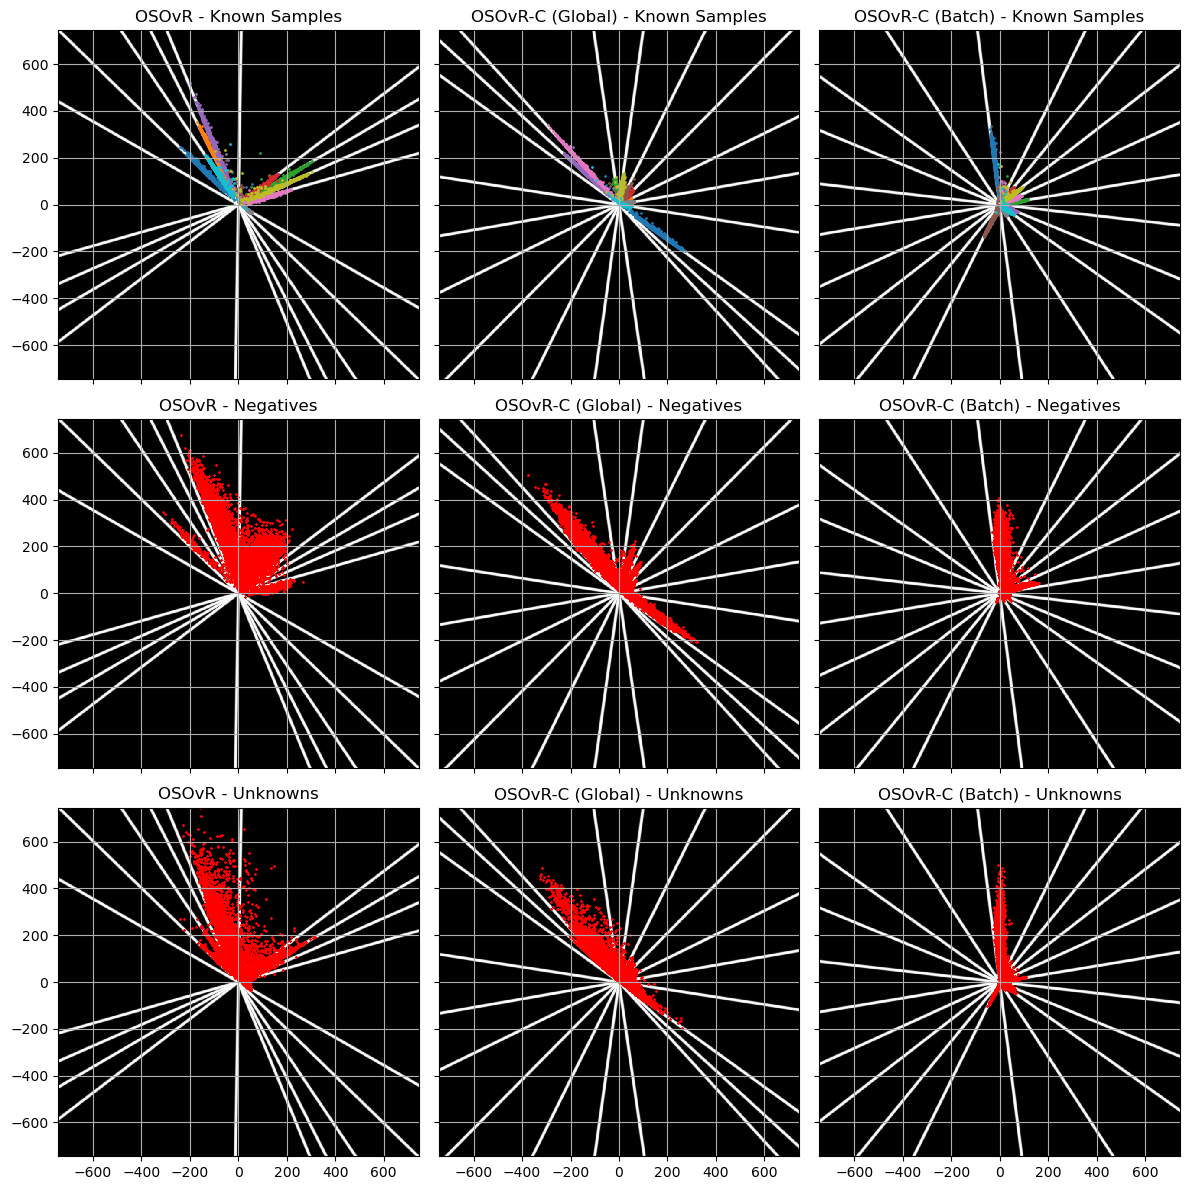

In [17]:
SIGMA = 6
deef_feat_viz_sample_detail(data_info=osovr_C_data_info, sigma=SIGMA)

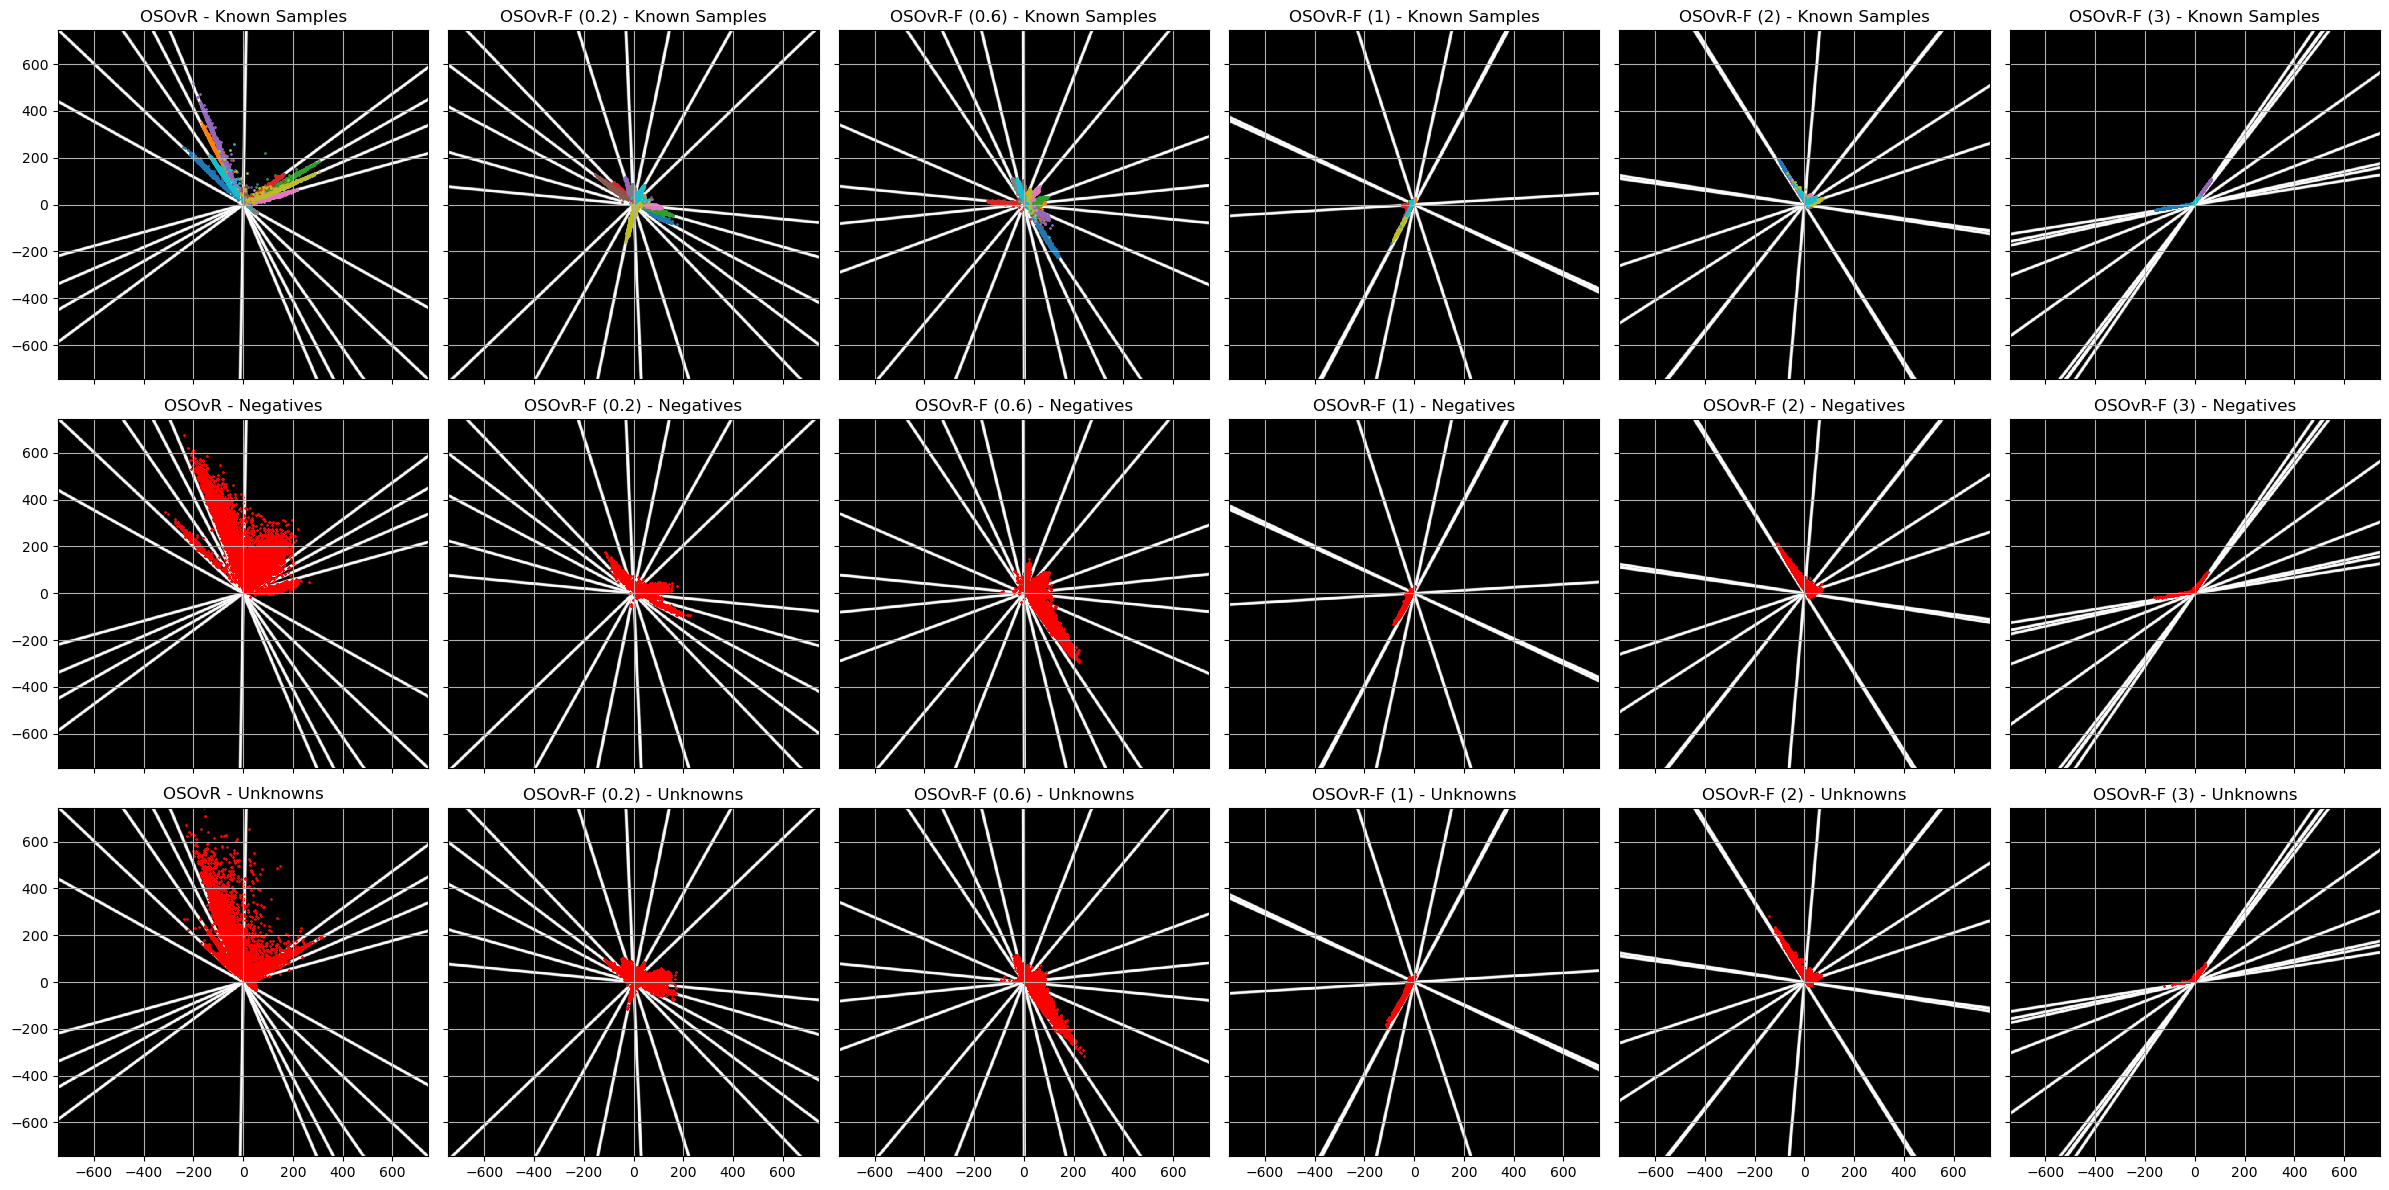

In [21]:
deef_feat_viz_sample_detail(data_info=osovr_F_data_info, sigma=SIGMA)

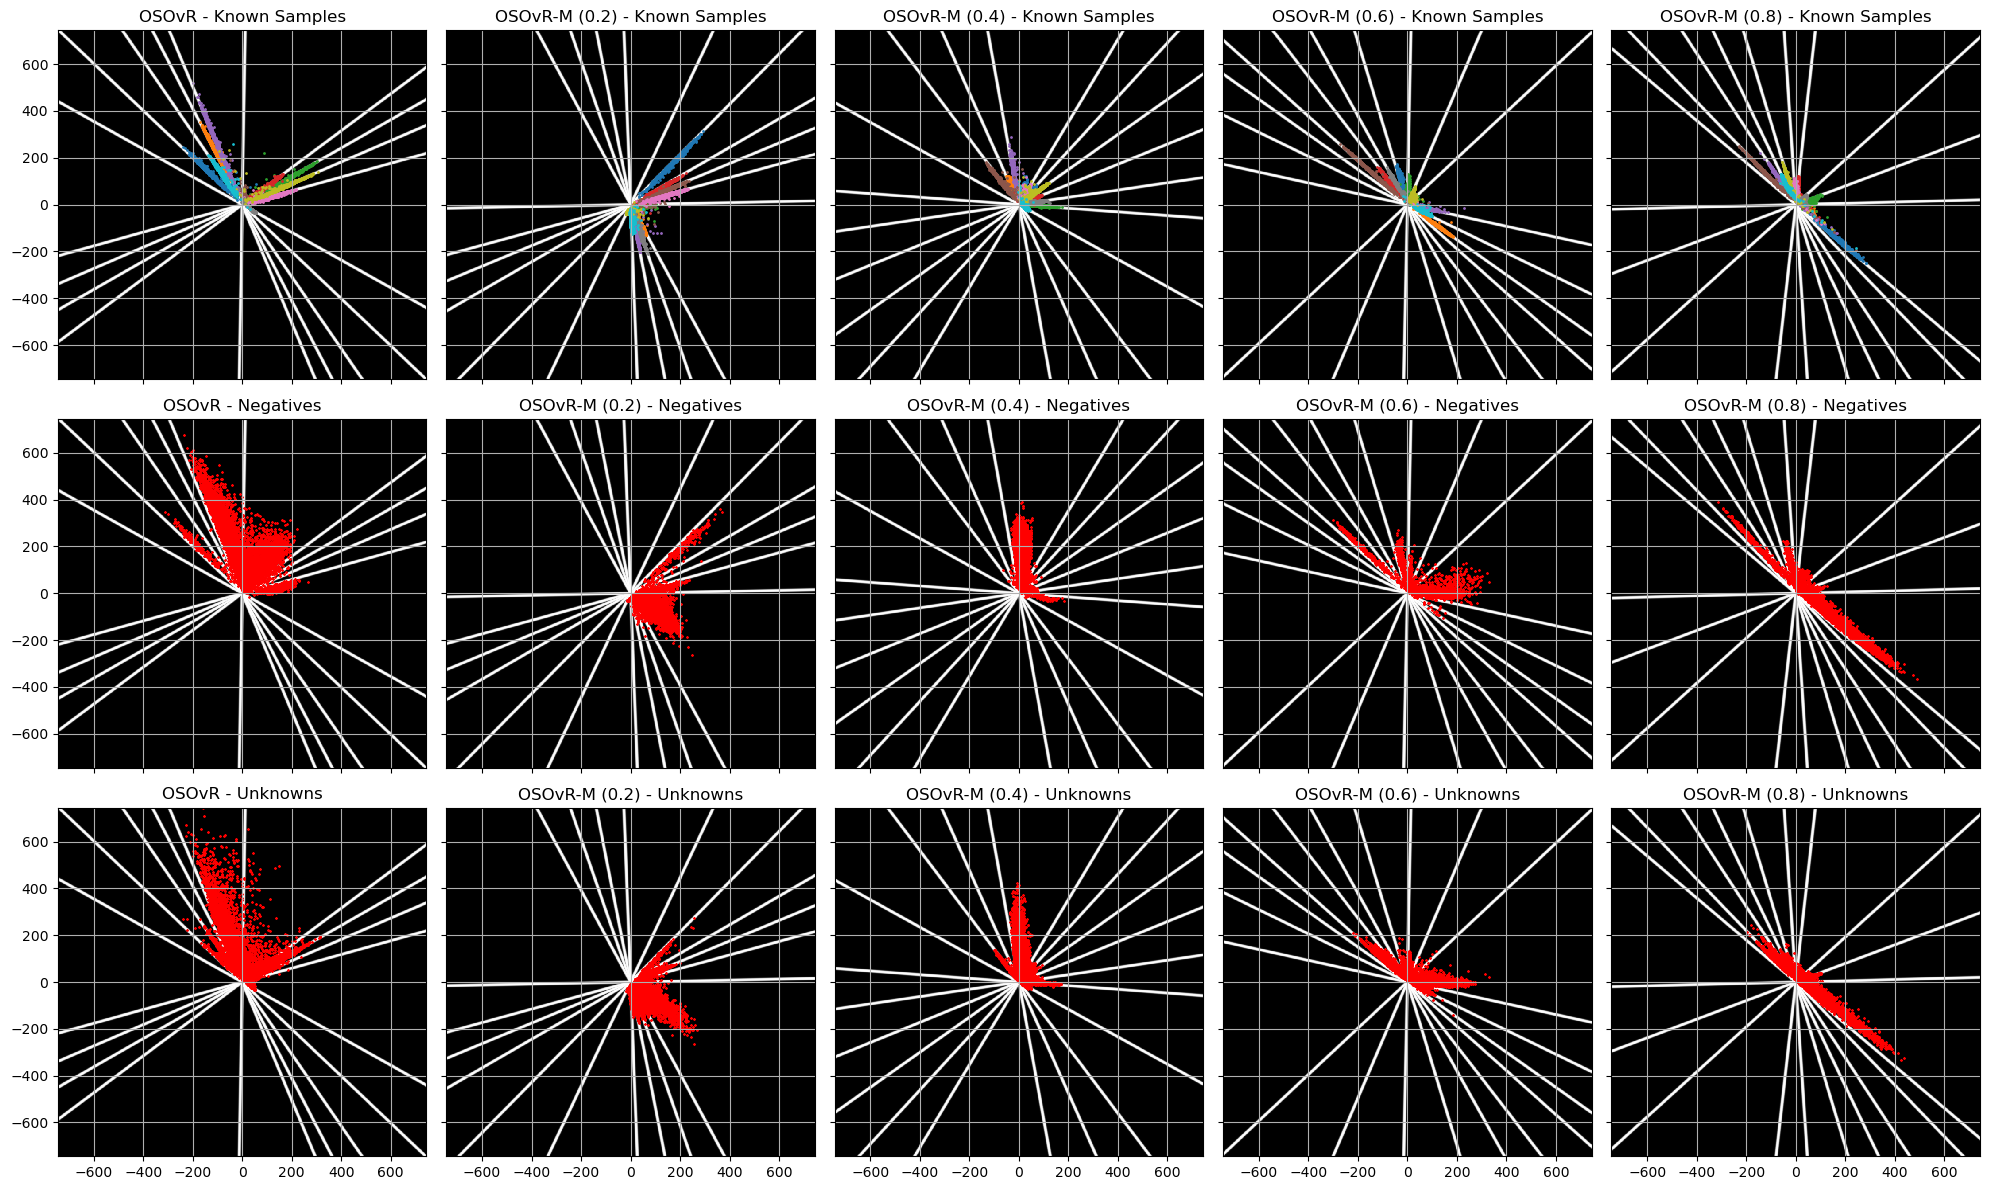

In [22]:
deef_feat_viz_sample_detail(data_info=osovr_M_data_info, sigma=SIGMA)

## OSCR and CCR@FPR

In [183]:
# data_info = osovr_C_data_info
# data_info = osovr_F_data_info
data_info = ovr_osovr_final_data_info

In [157]:
results = []
FPR_vals_all = np.linspace(1e-4,1,10**4)
FPR_vals = [1e-4,1e-3,1e-2,1e-1,1]

results = []
for item in data_info:

    info = item['info']
    oscr_neg_res_all, oscr_neg_res = [], []
    oscr_unkn_res_all, oscr_unkn_res = [], []

    for s in seeds:

        ccr, fpr_neg, fpr_unkn = recall_oscr_results(which=info[2], arch=info[1], dataset=info[0], seed = s, is_verbose= s==seeds[0] or s==seeds[-1])

        ccrs_all, _ = CCR_at_FPR(ccr, fpr_neg, FPR_vals_all)
        ccrs, _ = CCR_at_FPR(ccr, fpr_neg, FPR_vals)
        oscr_neg_res_all.append(ccrs_all)
        oscr_neg_res.append(ccrs)

        ccrs_all, _ = CCR_at_FPR(ccr, fpr_unkn, FPR_vals_all)
        ccrs, _ = CCR_at_FPR(ccr, fpr_unkn, FPR_vals)
        oscr_unkn_res_all.append(ccrs_all)
        oscr_unkn_res.append(ccrs)

    results.append([(np.nanmean(oscr_neg_res_all,axis=0), np.nanmean(oscr_neg_res,axis=0), np.nanstd(oscr_neg_res,axis=0)),
                    (np.nanmean(oscr_unkn_res_all,axis=0), np.nanmean(oscr_unkn_res,axis=0), np.nanstd(oscr_unkn_res,axis=0))])

/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet/EOS/oscr EOS
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet/EOS/oscr EOS
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_neg_All/OvR/oscr OvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_neg_All/OvR/oscr OvR


/tmp/ipykernel_2037101/2691088014.py:27: RuntimeWarning: Mean of empty slice
  (np.nanmean(oscr_unkn_res_all,axis=0), np.nanmean(oscr_unkn_res,axis=0), np.nanstd(oscr_unkn_res,axis=0))])


/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_FM_3-04/OvR/oscr OvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_FM_3-04/OvR/oscr OvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_neg_All/OpenSetOvR/oscr OpenSetOvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_neg_All/OpenSetOvR/oscr OpenSetOvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_FCM_3-b-04/OpenSetOvR/oscr OpenSetOvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_FCM_3-b-04/OpenSetOvR/oscr OpenSetOvR


In [184]:
results_plot = results
infos_plot = data_info

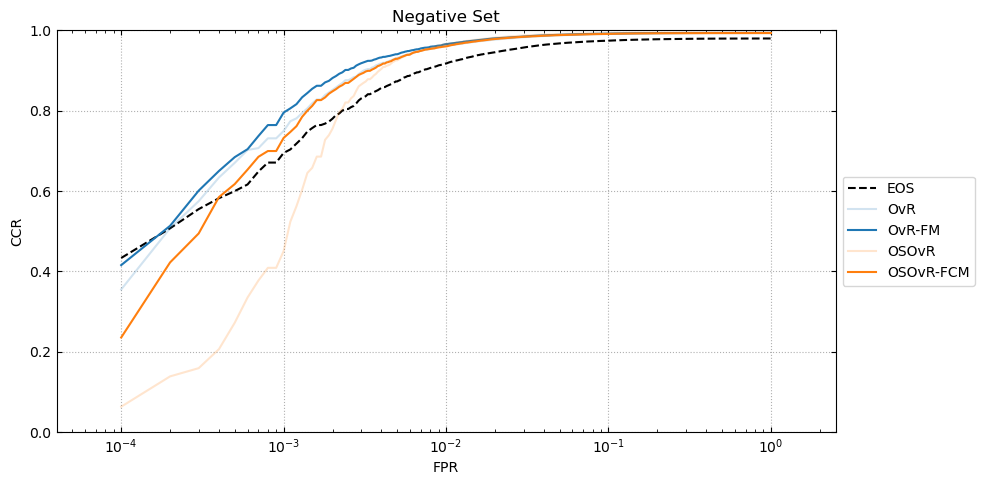

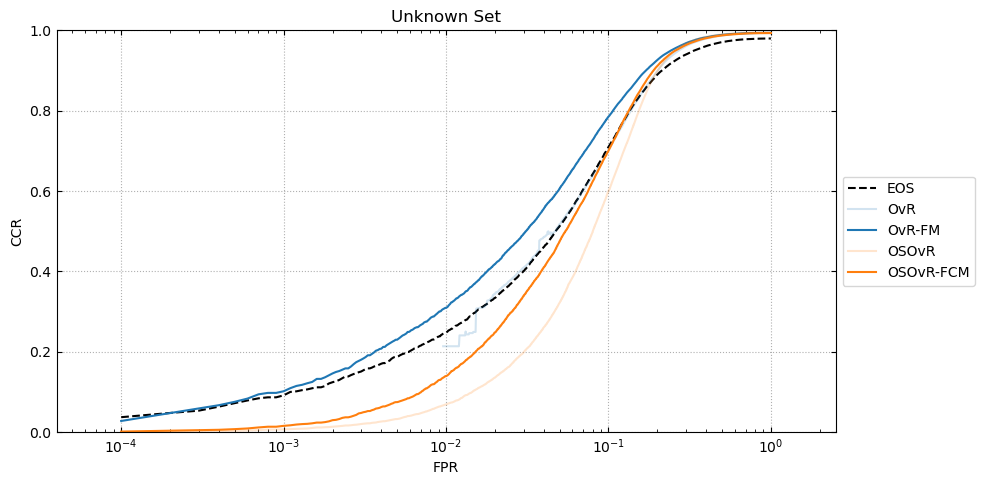

In [177]:
# plot with Negatives
plt.figure(figsize=(10,5))
for idx, res in enumerate(results_plot):
    plt.semilogx(FPR_vals_all, res[0][0], label=infos_plot[idx]['label'], alpha=infos_plot[idx]['alpha'] if 'alpha' in infos_plot[idx].keys() else 1, linestyle=infos_plot[idx]['linestyle'], color = infos_plot[idx]['color'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.ylabel("CCR")
plt.xlim((4e-5,2.5))
plt.ylim((0,1))
plt.title("Negative Set")
plt.tight_layout()
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
# plt.savefig(root.joinpath('oscr_neg.png'), bbox_inches="tight") 

# plot with Unknowns
plt.figure(figsize=(10,5))
for idx, res in enumerate(results_plot):
    plt.semilogx(FPR_vals_all, res[1][0], label=infos_plot[idx]['label'], alpha=infos_plot[idx]['alpha'] if 'alpha' in infos_plot[idx].keys() else 1, linestyle=infos_plot[idx]['linestyle'], color = infos_plot[idx]['color'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.ylabel("CCR")
plt.xlim((4e-5,2.5))
plt.ylim((0,1))
plt.title("Unknown Set")
plt.tight_layout()
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
# plt.savefig(root.joinpath('oscr_unkn.png'), bbox_inches="tight") 

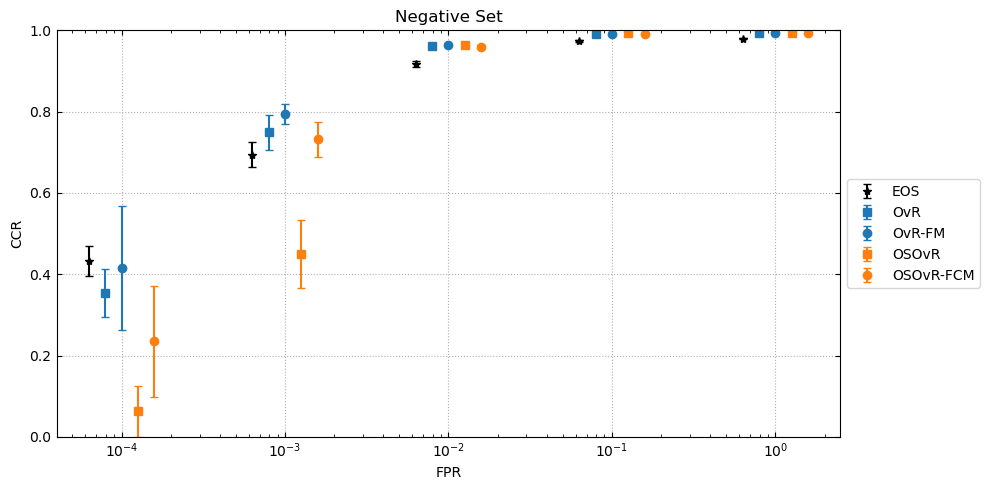

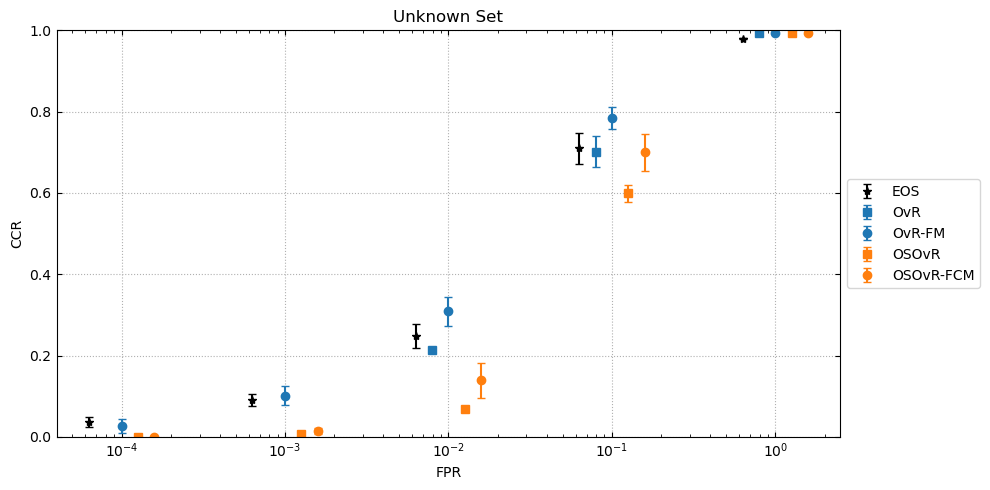

In [185]:
# trans = np.arange(len(results))
# trans = (trans-np.mean(trans))*0.4 + 1

trans_r = 2.5 if len(results_plot) > 8 else 10
trans = np.arange(len(results_plot)) * 0.1
trans = trans_r ** (trans-np.mean(trans))

fig, ax = plt.subplots(figsize=(10,5))
for idx, res in enumerate(results_plot):
    er1 = ax.errorbar([v * trans[idx] for v in FPR_vals], res[0][1], yerr=res[0][2], linestyle="none", capsize=3, 
                      marker=infos_plot[idx]['marker'], label=infos_plot[idx]['label'], color =infos_plot[idx]['color'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.xscale('log')
plt.ylabel("CCR")
plt.xlim((4e-5,2.5))
plt.ylim((0,1))
plt.title("Negative Set")
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(10,5))
for idx, res in enumerate(results_plot):
    er1 = ax.errorbar([v * trans[idx] for v in FPR_vals], res[1][1], yerr=res[1][2], linestyle="none", capsize=3,
                      marker=infos_plot[idx]['marker'], label=infos_plot[idx]['label'], color =infos_plot[idx]['color'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.xscale('log')
plt.ylabel("CCR")
plt.xlim((4e-5,2.5))
plt.ylim((0,1))
plt.title("Unknown Set")
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
plt.tight_layout()


In [36]:
print("CCR@FPR (Testset: Known + Negatives)")
print(*FPR_vals, sep='\t')
for idx, res in enumerate(results_plot):
    print(*[f"{x:.4f}" for x in res[0][1]], sep='\t')
print()
print("CCR@FPR (Testset: Known + Unknowns)")
print(*FPR_vals, sep='\t')
for idx, res in enumerate(results_plot):
    print(*[f"{x:.4f}" for x in res[1][1]], sep='\t')

CCR@FPR (Testset: Known + Negatives)
0.0001	0.001	0.01	0.1	1
0.3547	0.7491	0.9607	0.9908	0.9929
0.4028	0.7236	0.9586	0.9907	0.9926
0.3713	0.7980	0.9637	0.9915	0.9931
0.4153	0.7950	0.9651	0.9916	0.9933
0.2956	0.7359	0.9625	0.9909	0.9927
0.0629	0.4503	0.9650	0.9926	0.9939
0.0442	0.5353	0.9662	0.9927	0.9939
0.2602	0.7237	0.9614	0.9912	0.9929
0.1994	0.7162	0.9624	0.9911	0.9930
0.2351	0.7319	0.9596	0.9907	0.9929

CCR@FPR (Testset: Known + Unknowns)
0.0001	0.001	0.01	0.1	1
nan	nan	0.2134	0.7019	0.9929
nan	nan	0.2453	0.6977	0.9926
0.0317	0.1003	0.2839	0.7505	0.9931
0.0274	0.1014	0.3089	0.7848	0.9933
0.0257	0.0895	0.2790	0.7333	0.9927
0.0005	0.0066	0.0684	0.5991	0.9939
0.0009	0.0073	0.0707	0.6170	0.9939
0.0024	0.0151	0.1314	0.6996	0.9929
0.0012	0.0101	0.0982	0.6956	0.9930
0.0010	0.0152	0.1390	0.7000	0.9929


## Probability distribution

In [38]:
# data_info = osovr_C_data_info
# data_info = osovr_F_data_info
# data_info = ovr_C_data_info + osovr_C_data_info
data_info = ovr_combi_data_info + osovr_combi_data_info

['SmallScale', 'LeNet_neg_All', 'OvR']
['SmallScale', 'LeNet_CM_b-04', 'OvR']
['SmallScale', 'LeNet_FC_3-b', 'OvR']
['SmallScale', 'LeNet_FM_3-04', 'OvR']
['SmallScale', 'LeNet_FCM_3-b-04', 'OvR']
['SmallScale', 'LeNet_neg_All', 'OpenSetOvR']
['SmallScale', 'LeNet_CM_b-04', 'OpenSetOvR']
['SmallScale', 'LeNet_FC_3-b', 'OpenSetOvR']
['SmallScale', 'LeNet_FM_3-04', 'OpenSetOvR']
['SmallScale', 'LeNet_FCM_3-b-04', 'OpenSetOvR']


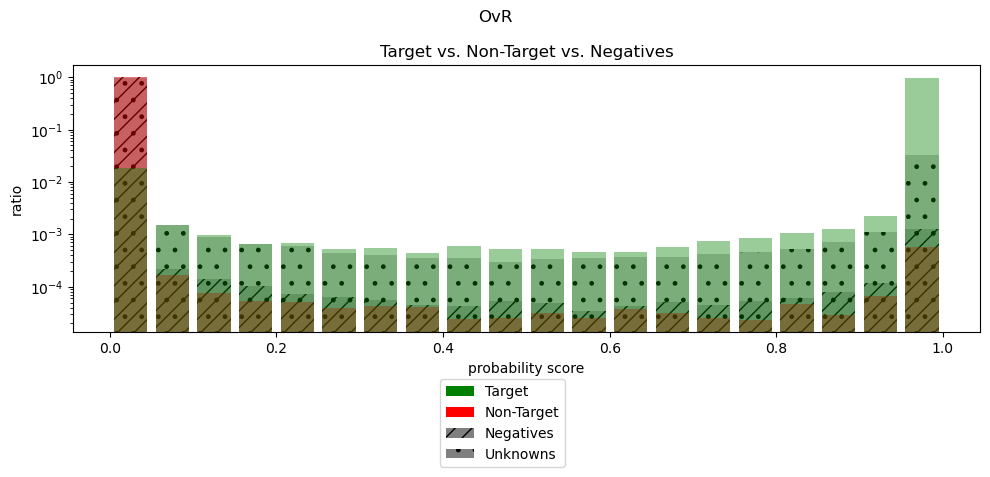

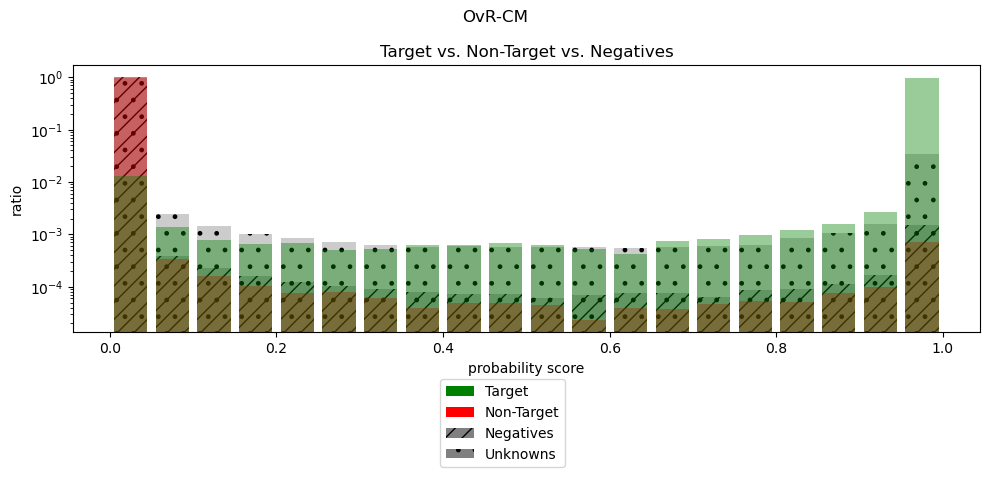

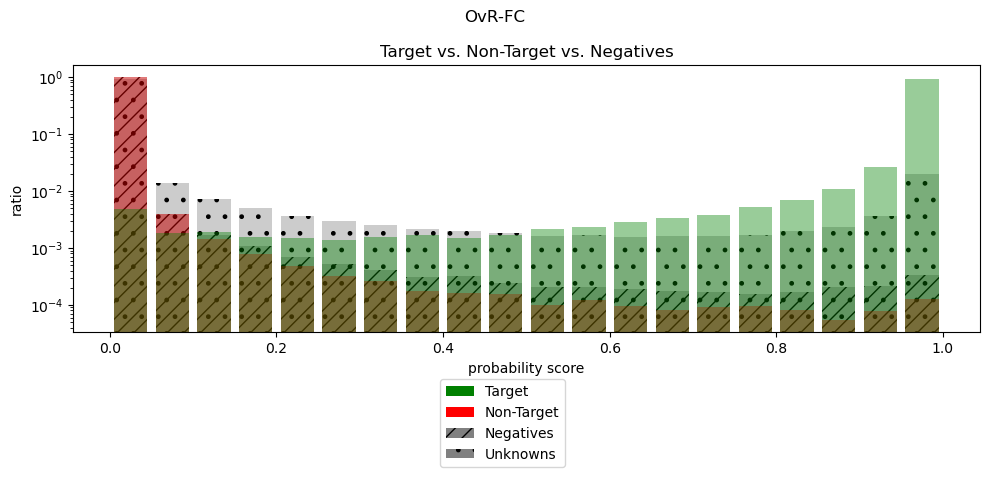

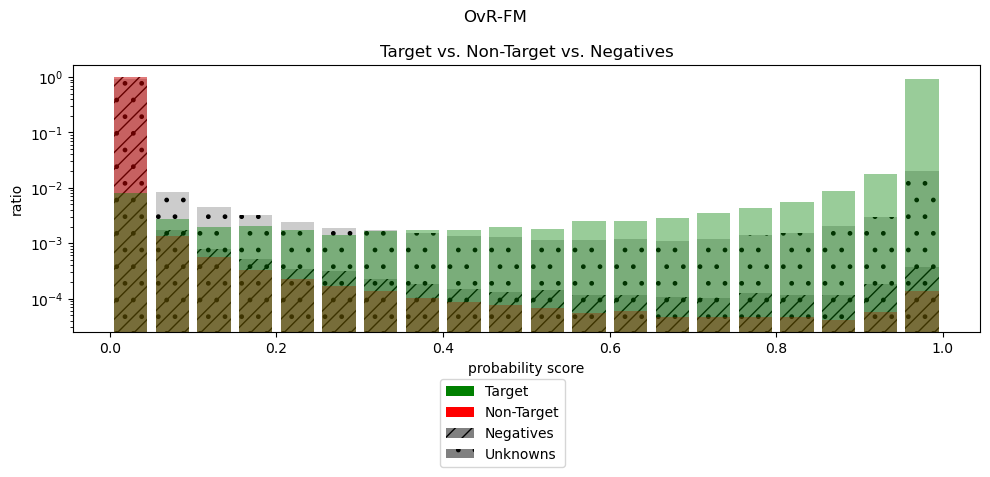

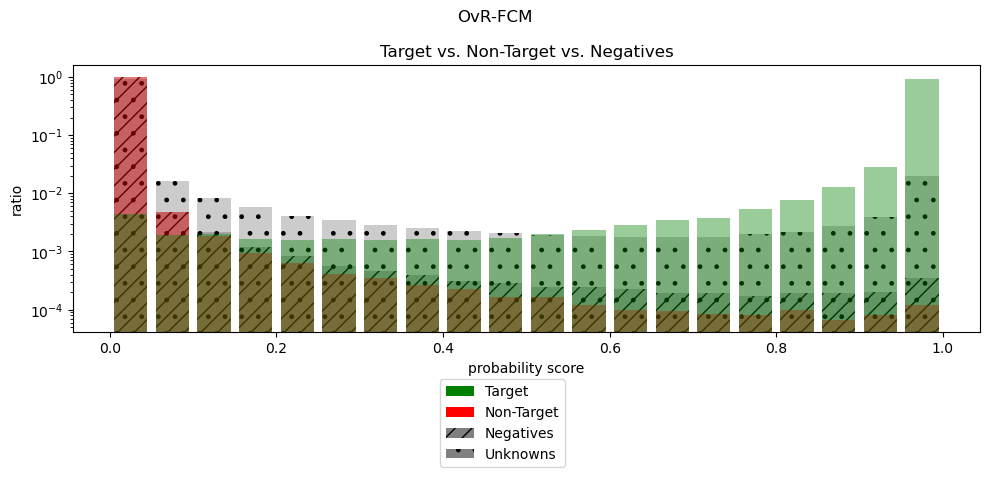

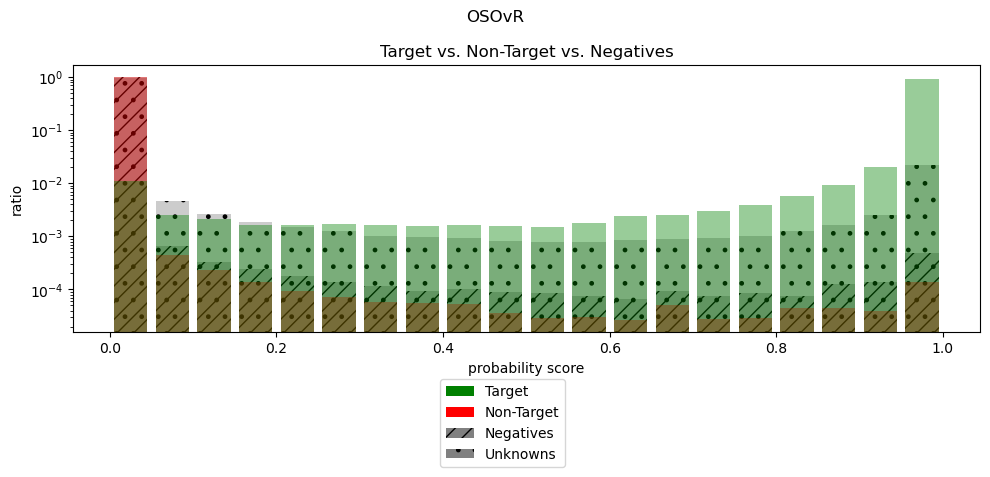

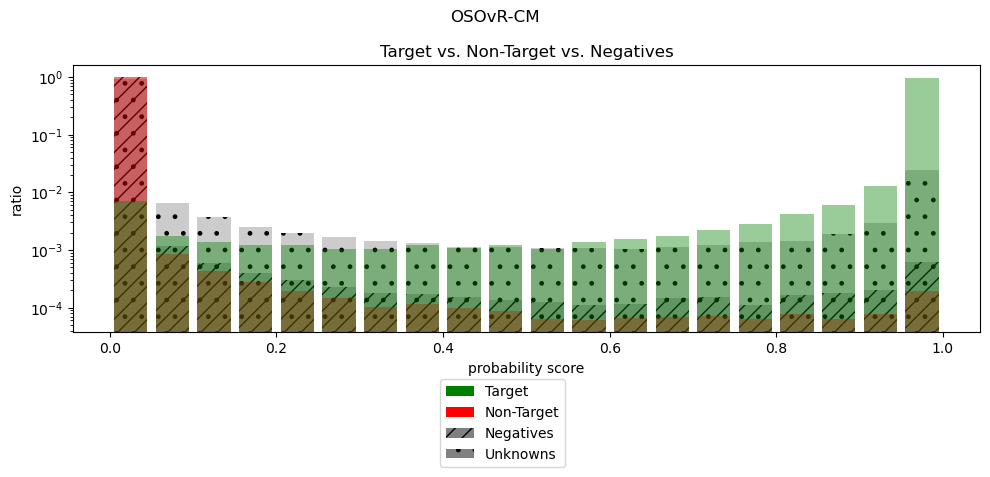

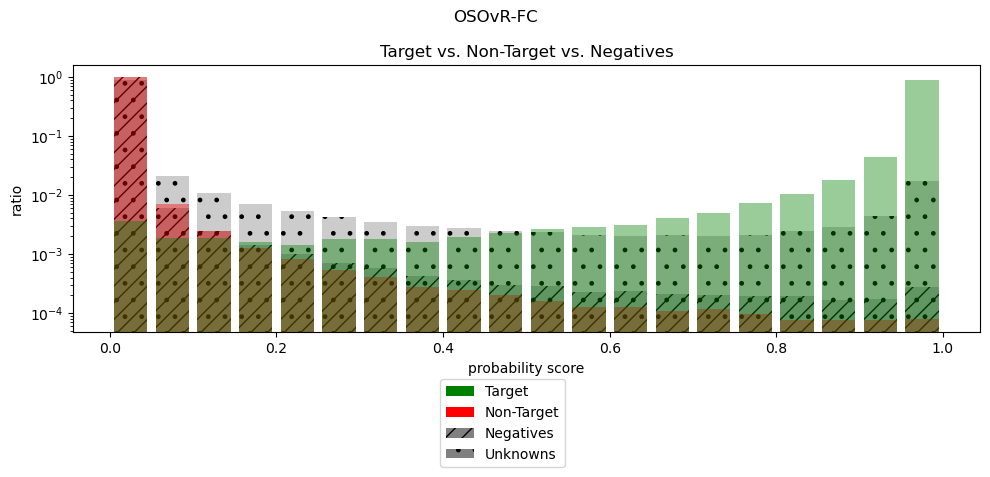

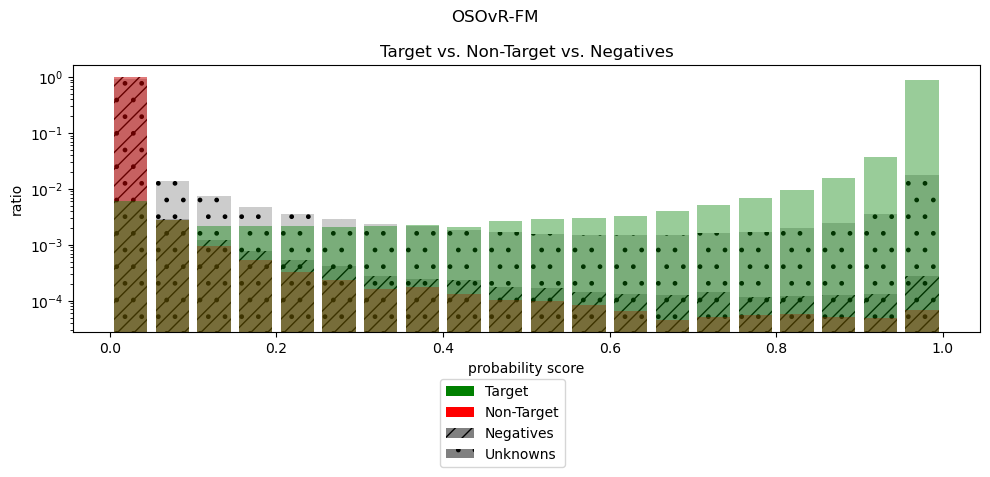

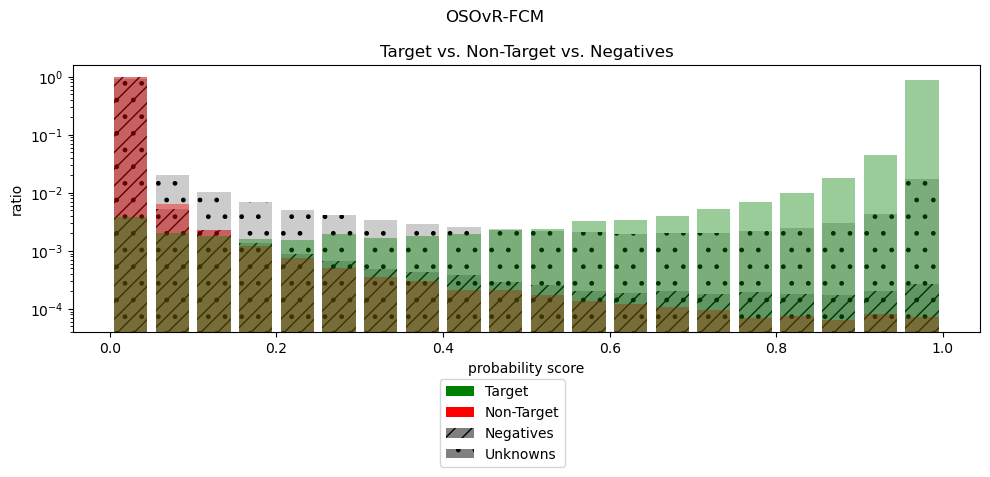

In [39]:
bins = np.linspace(0, 1, 20+1)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
legend_elements = [Patch(facecolor='green', label='Target'), Patch(facecolor='red', label='Non-Target'), Patch(facecolor='grey', label='Negatives', hatch='//'), Patch(facecolor='grey', label='Unknowns', hatch='.'),]

for item in data_info:
    fig, ax = plt.subplots(1,1,figsize=(10,5), sharex=True)
    target_probs_all = np.array([])
    non_target_probs_all = np.array([])
    negative_probs_all = np.array([])
    unknown_probs_all = np.array([])
    print(item['info'])
    for c in range(num_classes):
        for s in seeds:

            # Load evaluation results
            folder_path = f"./_results/{item['info'][0]}/_s{s}/eval_{item['info'][1]}/{item['info'][2]}"
            results = eval_results(folder_path)

            # Get known and unknown samples
            knowns = results.test_neg_gt != -1
            negatives = results.test_neg_gt == -1
            unknowns = results.test_unkn_gt == -1

            # Get target and non-target samples
            targets = np.logical_and(knowns, results.test_neg_gt == c)
            non_targets = np.logical_and(knowns, results.test_neg_gt != c)

            # Get probabilities for each item
            target_probs_all = np.append(target_probs_all, results.test_neg_probs[targets,:][:,c])
            non_target_probs_all = np.append(non_target_probs_all, results.test_neg_probs[non_targets,:][:,c])
            negative_probs_all = np.append(negative_probs_all, results.test_neg_probs[negatives,:][:,c])
            unknown_probs_all = np.append(unknown_probs_all, results.test_unkn_probs[unknowns,:][:,c])

    # Get histogram info
    target_probs_all_hist, _ = np.histogram(target_probs_all, bins=bins, density=False)
    non_target_probs_all_hist, _ = np.histogram(non_target_probs_all, bins=bins, density=False)
    negative_probs_all_hist, _ = np.histogram(negative_probs_all, bins=bins, density=False)
    unknown_probs_all_hist, _ = np.histogram(unknown_probs_all, bins=bins, density=False)

    # Change it to ratio between 0 and 1
    target_probs_ratio = target_probs_all_hist/sum(target_probs_all_hist)
    non_target_probs_ratio = non_target_probs_all_hist/sum(non_target_probs_all_hist)
    negative_probs_ratio = negative_probs_all_hist/sum(negative_probs_all_hist)
    unknown_probs_ratio = unknown_probs_all_hist/sum(unknown_probs_all_hist)

    ax.bar(center, unknown_probs_ratio, align='center', width=width, color = 'black', alpha = 0.2, label='Unknowns', hatch='.')
    ax.bar(center, negative_probs_ratio, align='center', width=width, color = 'black', alpha = 0.2, label='Negatives', hatch='//')
    ax.bar(center, non_target_probs_ratio, align='center', width=width, color = 'red', alpha = 0.4, label='Non-Target')
    ax.bar(center, target_probs_ratio, align='center', width=width, color = 'green', alpha = 0.4, label='Target')
    ax.set_title('Target vs. Non-Target vs. Negatives')
    ax.set_xlabel('probability score')
    ax.set_ylabel('ratio')
    ax.set_yscale('log')
    ax.legend(handles=legend_elements, bbox_to_anchor=(.55, -.15))

    # ax[1].bar(center, unknown_probs_ratio, align='center', width=width, color = 'black', alpha = 0.2, label='Unknowns')
    # ax[1].bar(center, non_target_probs_ratio, align='center', width=width, color = 'red', alpha = 0.2, label='Non-Target')
    # ax[1].bar(center, target_probs_ratio, align='center', width=width, color = 'green', alpha = 0.2, label='Target')
    # ax[1].set_title('Target vs. Non-Target vs. Unknowns')
    # ax[1].set_xlabel('probability score')
    # ax[1].set_ylabel('ratio')
    # ax[1].set_yscale('log')
    # ax[1].legend(handles=legend_elements, bbox_to_anchor=(.6, -.15))

    fig.suptitle(f"{item['label']}")
    fig.tight_layout()

## Confidence progress

In [40]:

log_item_list = [('Loss/train', 'Loss', 'Training Loss'),
                 ('Loss/val', 'Loss', 'Validation Loss'),
                 ('Acc/train', 'Accuracy', 'Training Acc.'),
                 ('Acc/val', 'Accuracy', 'Validation Acc.'),
                 ('Conf/train_kn', 'Confidence', 'Training Known Confidence.'),
                 ('Conf/train_neg', 'Confidence', 'Training Negative Confidence.'),
                 ('Conf/val_kn', 'Confidence', 'Validation Known Confidence.'),
                 ('Conf/val_neg', 'Confidence', 'Validation Negative Confidence.'),]

for idx, item in enumerate(log_item_list):
    print(f"{idx} : {item[0]}")

0 : Loss/train
1 : Loss/val
2 : Acc/train
3 : Acc/val
4 : Conf/train_kn
5 : Conf/train_neg
6 : Conf/val_kn
7 : Conf/val_neg


In [43]:
# data_info = osovr_C_data_info
# data_info = osovr_F_data_info
data_info = ovr_combi_data_info + osovr_combi_data_info

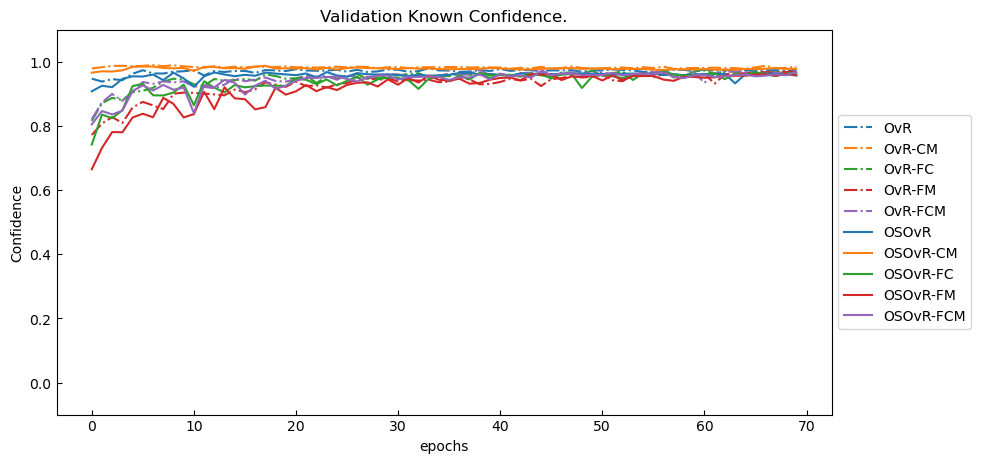

In [44]:
ITEM_IDX = 6

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

plt.figure(figsize=(10,5))
for idx, item in enumerate(data_info):

    logs = get_training_log(item['info'][0], item['info'][1], item['info'][2], log_item)

    plt.plot(logs, label=item['label'], linestyle=item['linestyle'], color=item['color'])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


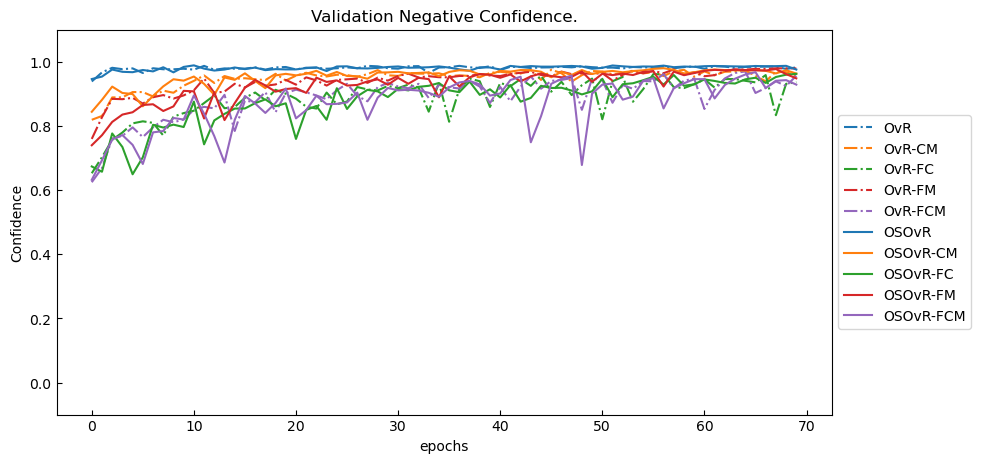

In [45]:
ITEM_IDX = 7

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

plt.figure(figsize=(10,5))
for idx, item in enumerate(data_info):

    logs = get_training_log(item['info'][0], item['info'][1], item['info'][2], log_item)

    plt.plot(logs, label=item['label'], linestyle=item['linestyle'], color=item['color'])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')